In [1]:
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time
import warnings

import scipy.ndimage.filters
import scipy.stats as stats

from IPython.display import display, clear_output

import nelpy as nel
import nelpy.plotting as npl

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nelpy import hmmutils
from nelpy.decoding import k_fold_cross_validation
from nelpy.decoding import decode1D

# Set default figure aesthetics
npl.setup(font_scale=1.0)

%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
# FFB! Worked with pandas 0.18.1, and 0.19.2, but not 0.20.x

datadirs = ['/home/etienne/Dropbox/neoReader/',
            'C:/Etienne/Dropbox/neoReader/',
            'D:/Dropbox/neoReader/']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

if fileroot is None:
    raise FileNotFoundError('datadir not found')

load_from_nel = True

# loaf from nel file:
if load_from_nel:
    jar = nel.load_pkl(fileroot + 'gor01_all_processed.nel')
    df = jar.df
    exp_data = jar.exp_data
    aux_data = jar.aux_data
    del jar
    
    jar = nel.load_pkl('spatial_info_vs_shuffle_ds20_gor01.nel')
    results_perm = jar.results
    
    jar = nel.load_pkl('spatial_info_vs_shuffle_ds20_gor01_rolled.nel')
    results_roll = jar.results
    del jar

# Draw real place fields

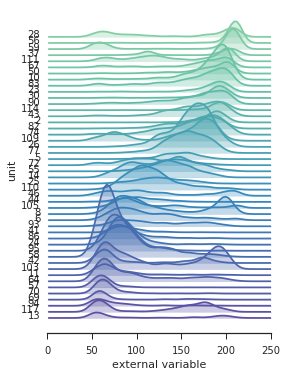

In [15]:
session_time, segment = '1-22-43', 'long'
session_time, segment = '16-40-19', 'short'

PBEs = tc = aux_data[session_time][segment]['PBEs']
st_run = aux_data[session_time][segment]['st_run']
tc = aux_data[session_time][segment]['tc']
tc_placecells = aux_data[session_time][segment]['tc_placecells']

#####################################################################

NUM_COLORS = tc_placecells.n_units * 4

cm = plt.get_cmap('Spectral_r')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
clist = np.roll(clist, 0, axis=0)

npl.set_palette(clist)

with npl.FigureManager(show=True, figsize=(4,6)) as (fig, ax):
    ax = npl.plot_tuning_curves1D(tc_placecells.smooth(sigma=3), pad=2.5);
    ax.set_xlim(0,250)

# Compute virtual tuning curves...

In [21]:
# session_time, segment = ('16-40-19', 'short') # example session

num_states = 30 # number of states for PBE HMM
ds = 0.02 # 20 ms bin size for PBEs
ds_run = 0.1
ds_50ms = 0.05
min_tc_duration = 0 # mininmum observation time in seconds, before a bin contributes to the tuning curve
sigma_tc = 4 # 4 cm smoothing on tuning curves

vtcs = []

k_folds = 5

st = aux_data[session_time][segment]['st_run']
PBEs = aux_data[session_time][segment]['PBEs']

X = [ii for ii in range(PBEs.n_epochs)]

description = (session_time, segment)

print("session: {}".format(description))

st_no_ripple = st[~exp_data[session_time]['mua_epochs']]

pos = exp_data[session_time]['pos1d'] # should this be pos1d?

# smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_no_ripple = st_no_ripple.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

bst = bst_no_ripple

ext_nx=124
x0=0; xl=310;

xx_left = np.linspace(x0,xl,ext_nx+1)
xx_mid = np.linspace(x0,xl,ext_nx+1)[:-1]; xx_mid += (xx_mid[1]-xx_mid[0])/2

for kk, (training, validation) in enumerate(k_fold_cross_validation(X, k=k_folds)):     
    print('  fold {}/{}'.format(kk+1, k_folds))

    PBEs_train = PBEs[training]
    PBEs_test = PBEs[validation]

    # train HMM on all training PBEs
    hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
    hmm.fit(PBEs_train)

    # reorder states according to transmat ordering
    transmat_order = hmm.get_state_order('transmat')
    hmm.reorder_states(transmat_order)

    # compute spatial info on non-shuffled data:
    xpos = pos.asarray(at=bst.centers).yvals

    ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
    ext_x = ext_x.astype(float)
    ext_x[ext_x==0] = np.nan
    ext_x[ext_x>=ext_nx] = np.nan

    extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)

    vtc = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
    vtc = vtc.smooth(sigma=sigma_tc)
    
    vtc.reorder_units(inplace=True)
    
    vtcs.append(vtc)
    

session: ('16-40-19', 'short')
  fold 1/5
  fold 2/5
  fold 3/5
  fold 4/5
  fold 5/5


In [22]:
NUM_COLORS = vtc.n_units + 2

cm = plt.get_cmap('viridis')
clist = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

npl.set_palette(clist)

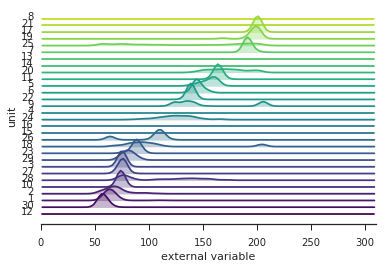

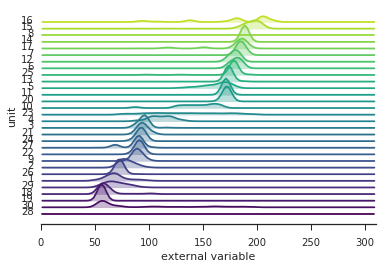

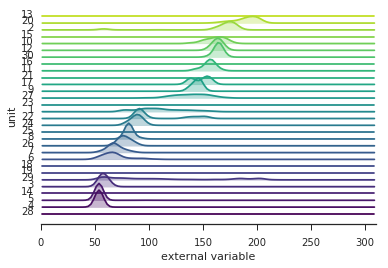

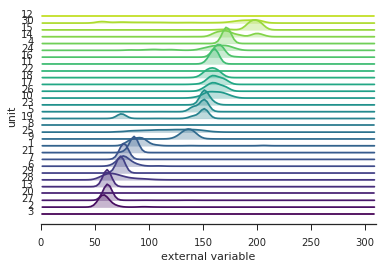

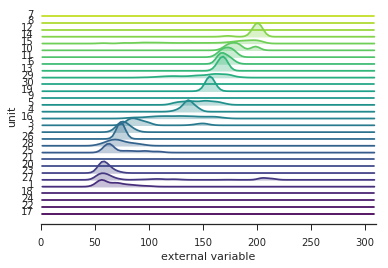

In [24]:
for vtc in vtcs:
    npl.plot_tuning_curves1D(vtc, pad=0.1)
    plt.show()

In [116]:
# train HMM on all training PBEs
hmm = nel.hmmutils.PoissonHMM(n_components=num_states, random_state=0, verbose=False)
hmm.fit(PBEs)

# reorder states according to transmat ordering
transmat_order = hmm.get_state_order('transmat')
hmm.reorder_states(transmat_order)

# compute spatial info on non-shuffled data:
xpos = pos.asarray(at=bst.centers).yvals

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)

vtc_ = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc_ = vtc_.smooth(sigma=sigma_tc)

vtc_.reorder_units(inplace=True)

# normalize position distributions for each state (FFB! This will affect decoding! But it's not the only "correct" way to normalize!)
vtc_._ratemap = (vtc_.ratemap.T / vtc_.ratemap.sum(axis=1)).T

pdf saved successfully...
png saved successfully...
svg saved successfully...


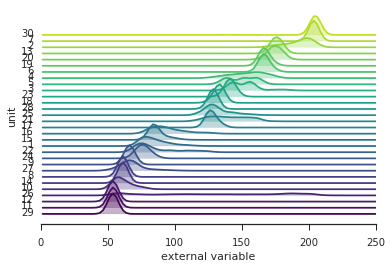

In [128]:
ax = npl.plot_tuning_curves1D(vtc_, pad=0.075)
ax.set_xlim(0, 250)
npl.savefig('vtc_distr', formats=['pdf', 'png', 'svg'])

pdf saved successfully...
png saved successfully...
svg saved successfully...


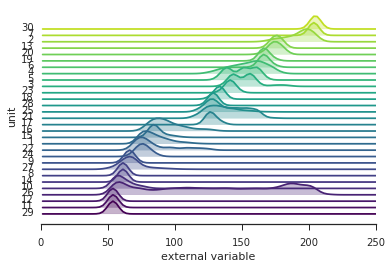

In [130]:
ax = npl.plot_tuning_curves1D(vtc_, normalize=True, pad=0.5)
ax.set_xlim(0, 250)
npl.savefig('vtc_normalized', formats=['pdf', 'png', 'svg'])

figures/vtc_shuffled.pdf already exists!
figures/vtc_shuffled.png already exists!
figures/vtc_shuffled.svg already exists!


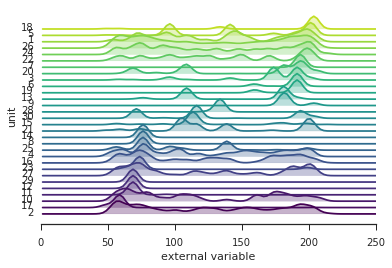

In [173]:
shuffled_pos = copy.deepcopy(pos)

# shuffled_pos._ydata = shuffled_pos._ydata[:, np.random.permutation(pos.n_samples)]

# shuffled_pos._interp = None # necessary so that new interpolant is used, and not old one, before shuffle
xpos = shuffled_pos.asarray(at=bst.centers).yvals
xpos = xpos[np.random.permutation(len(xpos))]

ext_x = np.digitize(xpos, xx_left) - 1 # spatial bin numbers
ext_x = ext_x.astype(float)
ext_x[ext_x==0] = np.nan
ext_x[ext_x>=ext_nx] = np.nan

extern = hmm.fit_ext(X=bst_no_ripple, ext=ext_x, n_extern=ext_nx)
# transform into ratemap shape

vtc_shfl = nel.TuningCurve1D(ratemap=extern, min_duration=min_tc_duration, extmin=x0, extmax=xl)
vtc_shfl = vtc_shfl.smooth(sigma=sigma_tc)

vtc_shfl.reorder_units(inplace=True)

# normalize position distributions for each state (FFB! This will affect decoding! But it's not the only "correct" way to normalize!)
vtc_shfl._ratemap = (vtc_shfl.ratemap.T / vtc_shfl.ratemap.sum(axis=1)).T

ax = npl.plot_tuning_curves1D(vtc_shfl, normalize=True, pad=0.5)
ax.set_xlim(0, 250)

# results[(session_time, segment)]['shuffled'].extend(vtc.spatial_information().tolist())

# npl.savefig('vtc_shuffled', formats=['pdf', 'png', 'svg'])

pdf saved successfully...
png saved successfully...
svg saved successfully...


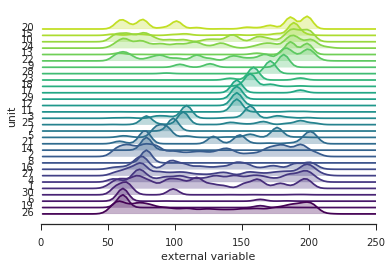

In [166]:
ax = npl.plot_tuning_curves1D(vtc_shfl, normalize=True, pad=0.5)
ax.set_xlim(0, 250)
# npl.savefig('vtc_shuffled3', formats=['pdf', 'png', 'svg'])